In [90]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import pylab as pl
import geopandas as gpd
import folium
from folium import plugins

In [91]:
# set up datasets
root = os.getcwd()
cities = pd.read_csv(root + "/cities.csv")
stations = pd.read_csv(root + "/stations.csv")
tracks = pd.read_csv(root + "/tracks.csv")
lines = pd.read_csv(root + "/lines.csv")
track_lines = pd.read_csv(root + "/track_lines.csv")

In [92]:
id_list = []
name_list = []
for i in cities.index:
    if cities.country[i] in ["Scotland", "England"]:    
        id_list.append(cities.id[i])
        name_list.append(cities.name[i])
print(id_list)
print(name_list)

[5, 20, 26, 45, 48, 65, 68, 72, 97, 89, 69]
['Aberdeen', 'Birmingham', 'Bristol', 'Edinburgh', 'Glasgow', 'Leeds', 'Liverpool', 'Manchester', 'Plymouth', 'Newcastle-on-Tyne', 'London']


In [93]:
city_dict = {}
for i in range(0, len(id_list)):
    line = lines[lines.city_id == id_list[i]]
    track_line = track_lines[track_lines.city_id == id_list[i]]
    track = tracks[tracks.city_id == id_list[i]].drop(['buildstart', 'opening', 'closure', 'city_id'], axis = 1)
    track.columns = ['section_id','geometry','length']
    track_line = pd.merge(track_line, track)
    track_line = track_line.drop(['id', 'created_at', 'updated_at', 'city_id'], axis = 1)
    track_line.columns = ['section_id', 'id', 'geometry', 'length']
    line = pd.merge(track_line, line)
    city_dict[name_list[i]] = line

In [94]:
data_cities = {}
for key, value in city_dict.items():
    if key not in data_cities:
        data_cities[key] = {}
    for i in range(len(value)):
        coord = value.iloc[i].geometry.split('(')[1].split(')')[0].split(',')
        for j in range(len(coord)):
            longitude = coord[j].split(' ')[0]
            latitude = coord[j].split(' ')[1]
            if value.url_name[i] in data_cities[key]:
                data_cities[key][value.url_name[i]].append([longitude, latitude])
            else:
                data_cities[key][value.url_name[i]] = [[longitude, latitude]]

[['-0.194322714583308', '51.601782193562'], ['-0.198108517367871', '51.6033788295533'], ['-0.201286722182402', '51.6046851263308'], ['-0.205937183622922', '51.6067170688518'], ['-0.207619762643219', '51.607399200592'], ['-0.20953603318128', '51.6079361907075'], ['-0.134811774021131', '51.5654183866782'], ['-0.134845825332036', '51.5660675034825'], ['-0.135129586309603', '51.5668718310053'], ['-0.135821963105258', '51.5676620336622'], ['-0.136845654102899', '51.5690302805386'], ['-0.138765074649768', '51.5711180818428'], ['-0.14324372364365', '51.5757904327528'], ['-0.144523337334761', '51.576724845264'], ['-0.146826641995119', '51.577897803992'], ['-0.148074265343467', '51.5785737325619'], ['-0.151721164380518', '51.5801442336544'], ['-0.161926084558161', '51.5856703756967'], ['-0.16461327333198', '51.587002115162'], ['-0.113222823474132', '51.5026004499487'], ['-0.122205771127057', '51.506754693639'], ['-0.164614540905063', '51.5869930000435'], ['-0.167802827210352', '51.5891778344187

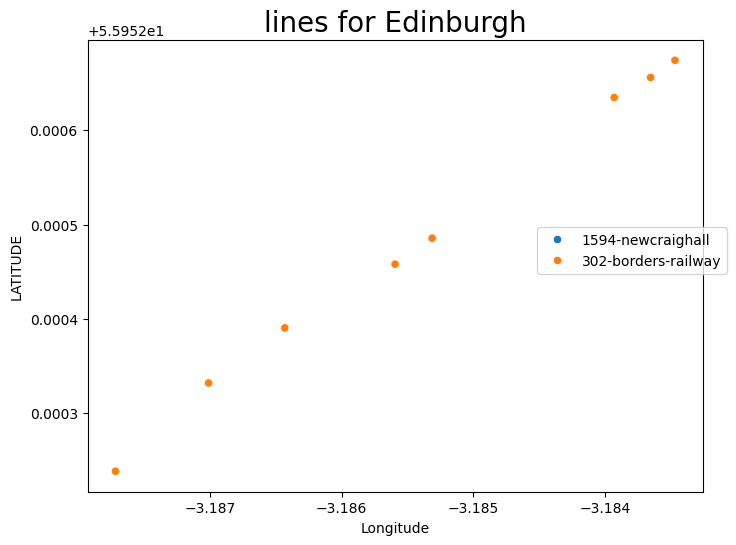

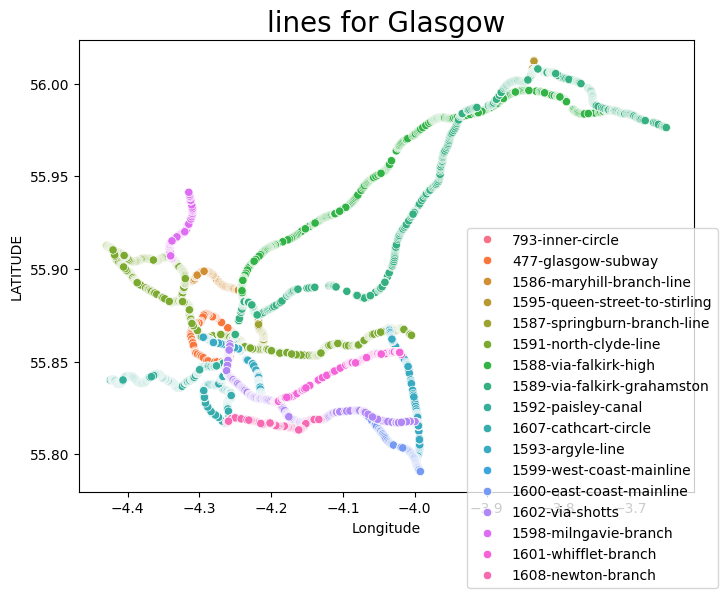

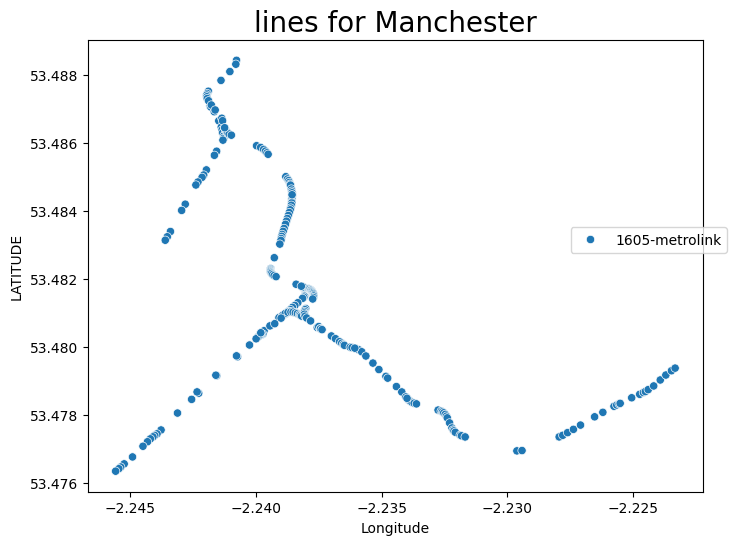

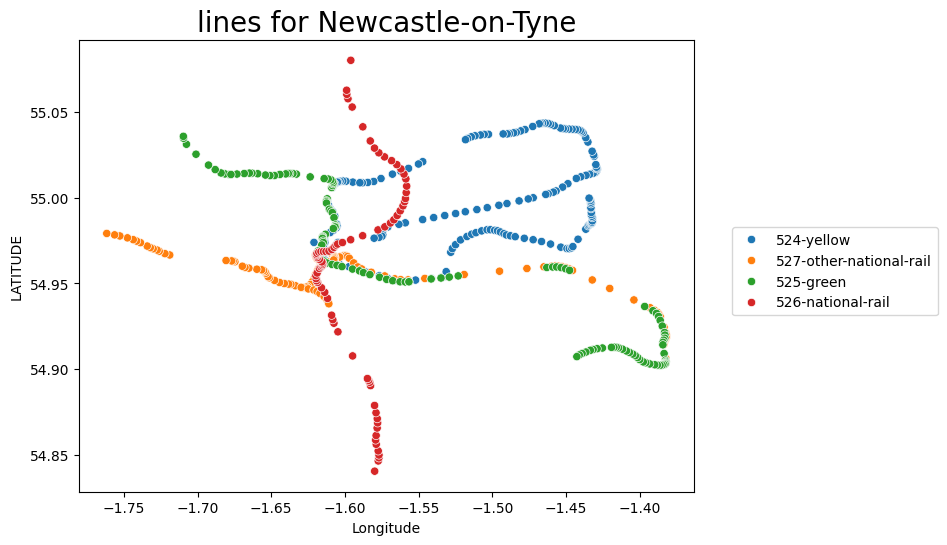

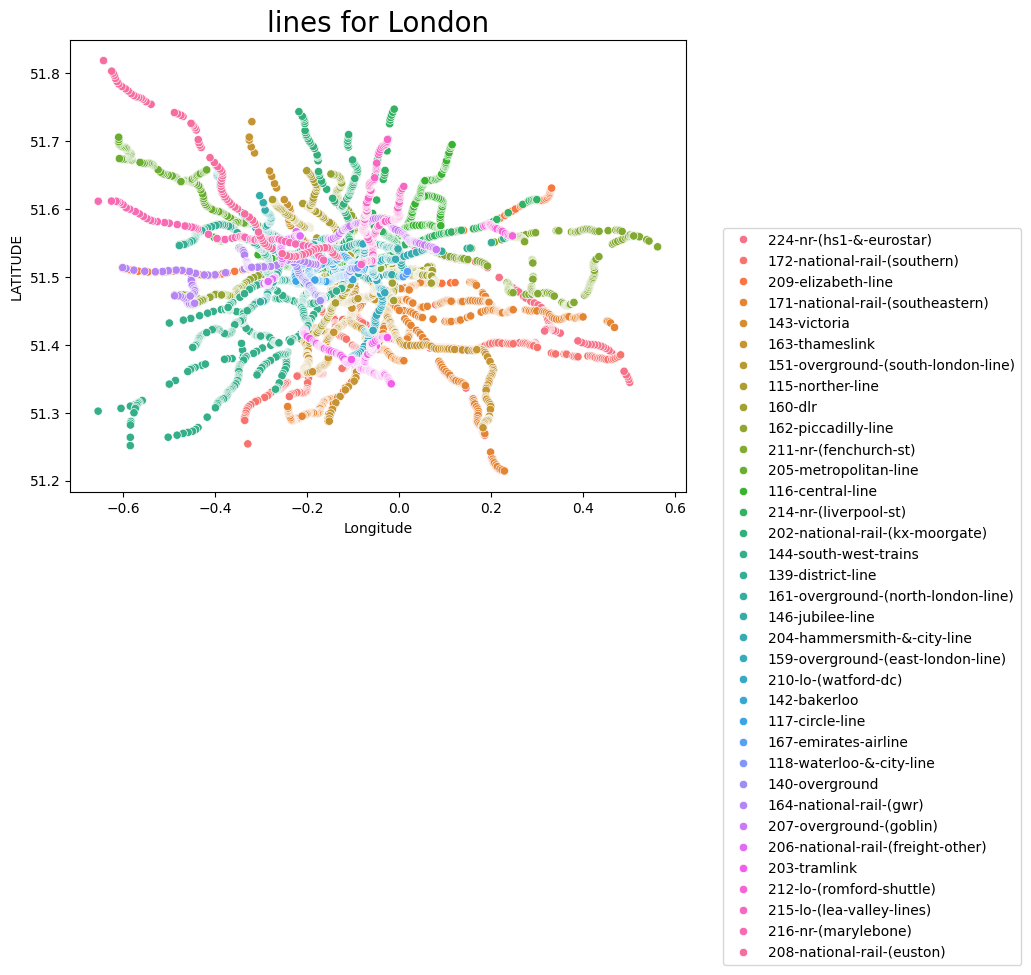

In [95]:
# visulization of cities before transforming to network
for key, values in data_cities.items():
    if values == {}:
        continue
    longitude = []
    latitude = []
    line = []
    for k, v in values.items():
        for i in range(len(v)):
            longitude.append(v[i][0])
            latitude.append(v[i][1])
            line.append(k)
            fix = pd.DataFrame({'x': longitude,'y': latitude,'z': line})
    fix['x'] = fix['x'].astype(float)
    fix['y'] = fix['y'].astype(float)
    plt.figure(figsize = (27, 27))
    plt.subplot(4, 3, 1) 
    ax = sns.scatterplot(x = "x", y = "y", hue = "z", data = fix)
    plt.legend(loc = 0, bbox_to_anchor=(1.05, 0.6))
    plt.title(f"lines for {key}", size = 20)
    #ax.get_legend().remove()
    ax.set(xlabel = 'Longitude', ylabel = 'LATITUDE')

In [232]:
import networkx as nx
from math import dist
Graphs = {}
data = {}

def euclidean_distance(station1, station2):
    return dist((float(station1[0]), float(station1[1])), (float(station2[0]), float(station2[1])))

useful_list = ["Edinburgh", "Glasgow", "Manchester", "Newcastle-on-Tyne", "London"]

for city in useful_list:
    G1 = nx.Graph()
    working_dict = data_cities[city]

    for line, coordinates in working_dict.items():
        for i in range(len(coordinates) - 1):
            node1 = tuple(map(float, coordinates[i]))
            node2 = tuple(map(float, coordinates[i + 1]))
            G1.add_node(node1)
            G1.add_node(node2)
            G1.add_edge(node1, node2)

    print(city)
    print(len(G1.edges()))
    lines = list(working_dict.keys())
    for i in range(len(lines) - 1):
        line1 = lines[i]
        line2 = lines[i + 1]

        closest_distance = float('inf')
        closest_stations = None

        for station1 in working_dict[line1]:
            for station2 in working_dict[line2]:
                distance = euclidean_distance(station1, station2)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_stations = (tuple(map(float, station1)), tuple(map(float, station2)))

        G1.add_edge(closest_stations[0], closest_stations[1])
    
    
    print(len(G1.edges()))
    Graphs[city] = G1

print(Graphs)


Edinburgh
8
9
Glasgow
4268
4282
Manchester
253
253
Newcastle-on-Tyne
534
537
London
7207
7241
{'Edinburgh': <networkx.classes.graph.Graph object at 0x00000233F9302810>, 'Glasgow': <networkx.classes.graph.Graph object at 0x0000023380896450>, 'Manchester': <networkx.classes.graph.Graph object at 0x00000233EF9CF110>, 'Newcastle-on-Tyne': <networkx.classes.graph.Graph object at 0x00000233EEA98710>, 'London': <networkx.classes.graph.Graph object at 0x00000233FA4A53D0>}


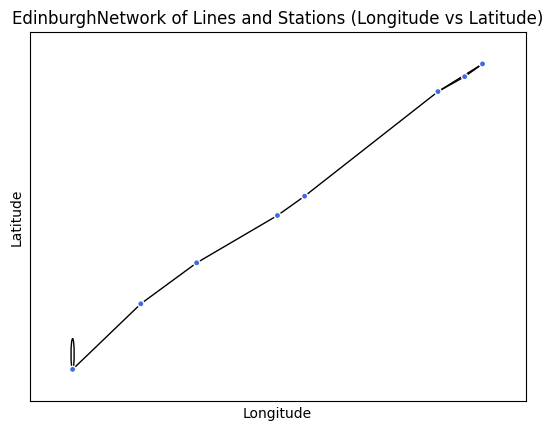

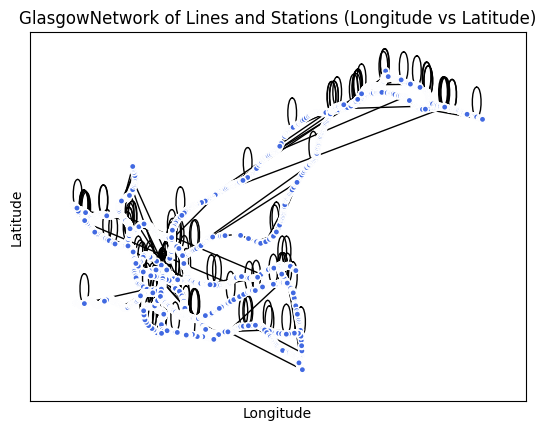

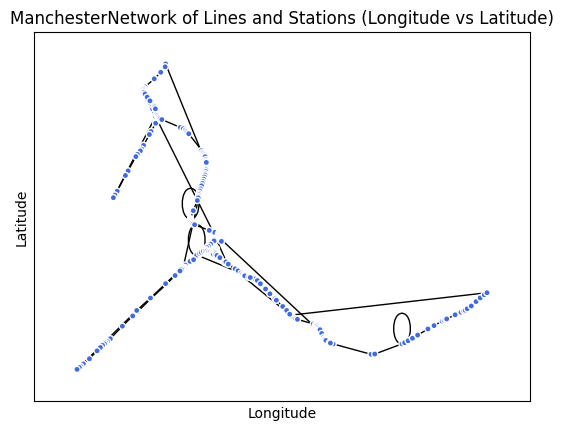

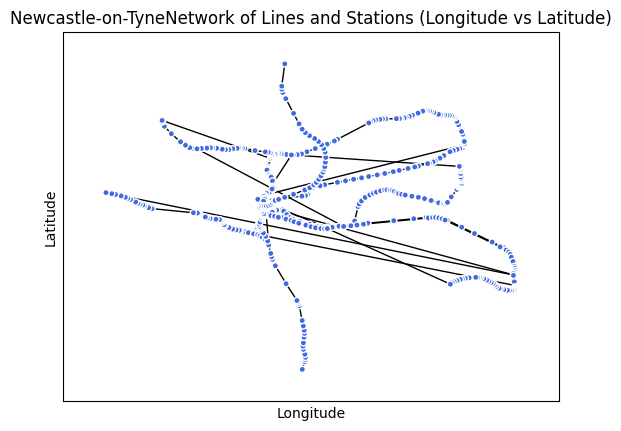

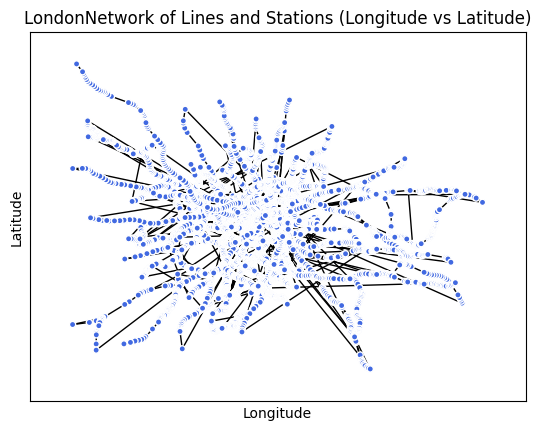

In [233]:
for name, G in Graphs.items():
    pos = {node: (float(node[0]), float(node[1])) for node in G.nodes()}  # Positions based on longitude and latitude

    edge_colors = [G.edges[edge]['line'] if 'line' in G.edges[edge] else 'black' for edge in G.edges]

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color=edge_colors)

    node_colors = [G.nodes[node]['line'] if 'line' in G.nodes[node] else 'royalblue' for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, linewidths=1, edgecolors='white')  # Set linewidths and edgecolors

    # labels = {node: f"{node}" for node in G.nodes()}
    # nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black', font_weight='bold')

    plt.title(f'{name} Network of Lines and Stations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [198]:
# for name, G in Graphs.items():
#     if name not in data:
#         data[name] = {}
#     connectivity = nx.node_connectivity(G)
#     min_node_cut = nx.minimum_node_cut(G)
#     data[name]["connectivity"] = connectivity
#     data[name]["min_node_cut"] = min_node_cut

#     print(f"{name} Connectivity for the whole network: {connectivity}")
#     print(f"{name} Minimum Node Cut for the whole network: {min_node_cut}")
# print(data)

In [241]:
data = {}

In [242]:
s = "connectivity"
for name, G in Graphs.items():
    if name not in data:
        data[name] = {}
    data[name][s] = 1
data["Manchester"][s] = 2
print(data)

{'Edinburgh': {'connectivity': 1}, 'Glasgow': {'connectivity': 1}, 'Manchester': {'connectivity': 2}, 'Newcastle-on-Tyne': {'connectivity': 1}, 'London': {'connectivity': 1}}


In [235]:
for name, G in Graphs.items():
    data[name]["eigenvector_centrality"] = nx.eigenvector_centrality(G, max_iter=50000)

In [216]:
for name, G in Graphs.items():
    data[name]["closeness_centrality"] = nx.closeness_centrality(G)

In [217]:
for name, G in Graphs.items():
    data[name]["degree_centrality"] = nx.degree_centrality(G)

In [236]:
# for name, G in Graphs.items():
#     data[name]["betweenness_centrality"] = nx.betweenness_centrality(G)

In [222]:
for name, G in Graphs.items():
    data[name]["katz_centrality"] = nx.katz_centrality(G)

In [243]:
for name, G in Graphs.items():
    data[name]["pagerank"] = nx.pagerank(G)

In [244]:
for name, G in Graphs.items():
    data[name]["density"] = nx.density(G)
    data[name]["centrality"] = nx.degree_centrality(G)

In [245]:
for name, G in Graphs.items():
    data[name]["num_edge"] = len(G1.edges())
    data[name]["num_node"] = len(G1.nodes())
    data[name]["average_degree"] = sum(dict(G.degree()).values()) / len(G)

In [246]:
# for name, G in Graphs.items():
    # eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=50000)
    # degree_centrality = nx.degree_centrality(G)
    # closeness_centrality = nx.closeness_centrality(G)
    # betweenness_centrality = nx.betweenness_centrality(G)
    # katz_centrality = nx.katz_centrality(G)
    # pagerank = nx.pagerank(G)
    # density = nx.density(G)
    # data[name]["eigenvector_centrality"] = eigenvector_centrality
    # data[name]["degree_centrality"] = degree_centrality
    # data[name]["closeness_centrality"] = closeness_centrality
    # data[name]["betweenness_centrality"] = betweenness_centrality
    # data[name]["katz_centrality"] = katz_centrality
    # data[name]["pagerank"] = pagerank
    # data[name]["density"] = density
    # data[name]["num_edge"] = len(G1.edges())
    # data[name]["num_node"] = len(G1.nodes())
    # data[name]["average_degree"] = sum(dict(G.degree()).values()) / len(G)
    # print(f"{name}'s centralities:", eigenvector_centrality, degree_centrality, closeness_centrality, betweenness_centrality, katz_centrality, pagerank, density)

for k, v in data.items():
    print(k, v)
    print(bool("London" in data))

Edinburgh {'connectivity': 1, 'pagerank': {(-3.1877171, 55.9522383): 0.12377282035592221, (-3.1870096, 55.9523319): 0.12333837500114082, (-3.1864306, 55.9523904): 0.12231881376457733, (-3.1855929, 55.952458): 0.12034996611871039, (-3.1853113, 55.9524856): 0.11674257457616503, (-3.1839281, 55.9526349): 0.16532808824814293, (-3.1834663, 55.9526744): 0.11407468096767064, (-3.1836515, 55.9526562): 0.11407468096767064}, 'density': 0.32142857142857145, 'centrality': {(-3.1877171, 55.9522383): 0.42857142857142855, (-3.1870096, 55.9523319): 0.2857142857142857, (-3.1864306, 55.9523904): 0.2857142857142857, (-3.1855929, 55.952458): 0.2857142857142857, (-3.1853113, 55.9524856): 0.2857142857142857, (-3.1839281, 55.9526349): 0.42857142857142855, (-3.1834663, 55.9526744): 0.2857142857142857, (-3.1836515, 55.9526562): 0.2857142857142857}, 'num_edge': 7241, 'num_node': 7242, 'average_degree': 2.25}
True
Glasgow {'connectivity': 1, 'pagerank': {(-4.2551723, 55.8575955): 0.0003430267616597898, (-4.25495